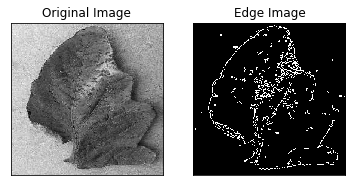

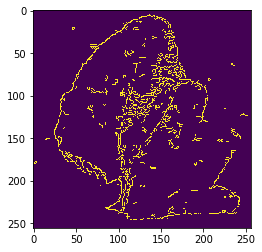

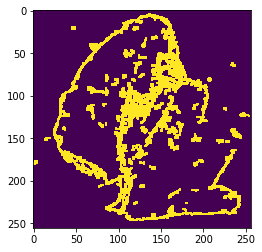

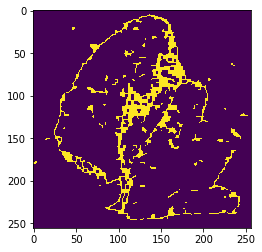

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_masking(filepath):
        BLUR = 21
        CANNY_THRESH_1 = 100
        CANNY_THRESH_2 = 200
        MASK_DILATE_ITER = 7
        MASK_ERODE_ITER = 7
        MASK_COLOR = (0.0,0.0,0.0) # In BGR format
        img1 = cv2.imread('test2.jpg',0)
        edges = cv2.Canny(img1,100,200)

        plt.subplot(121),plt.imshow(img1,cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(edges,cmap = 'gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

        plt.show()
        
        #-- Read image -----------------------------------------------------------------------
        img = cv2.imread(filepath)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)	
       
        #-- Edge detection -------------------------------------------------------------------
        edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
        plt.imshow( edges)
        plt.show()
        edges = cv2.dilate(edges, None)
        plt.imshow(edges)
        plt.show()
        edges = cv2.erode(edges, None)
        plt.imshow(edges)
        plt.show()
        
        #-- Find contours in edges, sort by area ---------------------------------------------
        contour_info = []
        contours, __ = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        # Previously, for a previous version of cv2, this line was: 
        #  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        # Thanks to notes from commenters, I've updated the code but left this note
        
        for c in contours:
            contour_info.append((c, cv2.isContourConvex(c), cv2.contourArea(c),))
        contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)

        max_contour = contour_info[0]
        
        #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
        # Mask is black, polygon is white

        mask = np.zeros(edges.shape)
        cv2.fillConvexPoly(mask, max_contour[0], (255))

        #-- Smooth mask, then blur it --------------------------------------------------------
        
        mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
        mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
        mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
        
        #-- Blend masked img into MASK_COLOR background --------------------------------------

        mask_stack = np.dstack([mask]*3)
        mask_stack  = mask_stack.astype('float32') / 255.0 # use float matrices
        img = img.astype('float32') / 255.0 # for easy blending

        masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) #blend
        masked = (masked * 255).astype('uint8')  #convert back to 8 bit
        
#         # split image into channels
#         c_red, c_green, c_blue = cv2.split(img)

#         # merge with mask got on one of a previous steps
#         img_a = cv2.merge((c_red, c_green, c_blue, mask.astype('float32') / 255.0))

#         # show on screen (optional in jupiter)
#         plt.imshow(img_a)
#         plt.show()

        fileName, fileExtension = filepath.split('.')
        fileName += '-masked.'
        filepath = fileName + fileExtension

        cv2.imwrite(filepath, masked)


image_masking("test2.jpg")


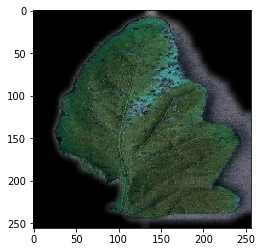

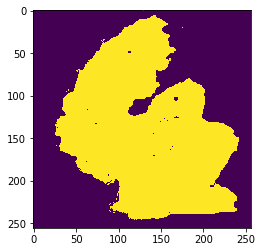

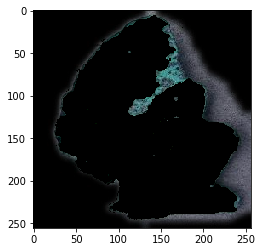

True

In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read
img = cv2.imread("test2-masked.jpg")
plt.imshow(img)
plt.show()

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
#mask2 = cv2.inRange(hsv, (0, 0, 0), (70, 255,255))
## slice the green
plt.imshow(mask)
plt.show()
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]

new = img-green
plt.imshow( new)
plt.show()
## save 
cv2.imwrite("test2-final.jpg", new)
